# Lab 5. TensorFlow and Convolutional Neural Network

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
CPU_ONLY = False

In [2]:
if CPU_ONLY: os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
print(f"TensorFlow version: {tf.__version__}")
print("CUDA version:")
print(os.popen('nvcc --version').read())
with_cuda = tf.test.is_built_with_cuda()
print(f"Can build with CUDA: {with_cuda}")
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)
print("Num GPUs Available: ", len(gpus))
for x in gpus: print(x)

TensorFlow version: 2.3.1
CUDA version:
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Fri_Feb__8_19:08:26_Pacific_Standard_Time_2019
Cuda compilation tools, release 10.1, V10.1.105

Can build with CUDA: True
Num GPUs Available:  1
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [4]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [5]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))
num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))
total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [6]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)
print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [7]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

# num_classes = 10
# # batch_size = 128
# batch_size = 64
# # epochs = 20
# epochs = sys.maxsize
accuracy_threshold = 0.977

In [8]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [9]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
directory=train_dir, shuffle=True, target_size=(IMG_HEIGHT, IMG_WIDTH),
class_mode='binary')

Found 2000 images belonging to 2 classes.


In [10]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
directory=validation_dir,target_size=(IMG_HEIGHT, IMG_WIDTH),class_mode='binary')

Found 1000 images belonging to 2 classes.


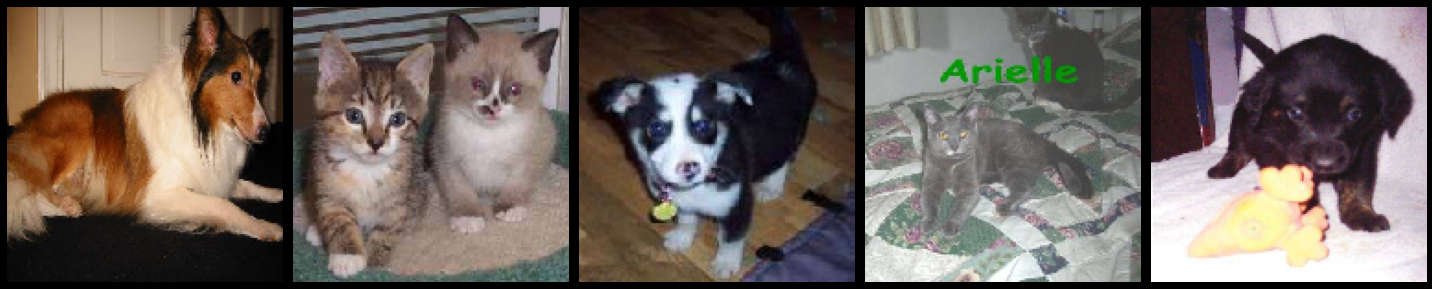

In [11]:
sample_training_images, _ = next(train_data_gen)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plotImages(sample_training_images[:5])

In [12]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

In [13]:
model.compile(optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

In [14]:
from tqdm.keras import TqdmCallback
from tqdm import tqdm_notebook
from livelossplot import PlotLossesKeras
import keras

In [15]:
class AccuracyStopping(keras.callbacks.Callback):
    def __init__(self, acc_threshold):
        super(AccuracyStopping, self).__init__()
        self._acc_threshold = acc_threshold

    def on_epoch_end(self, epoch, logs={}):
        train_acc = logs.get('accuracy') != None and logs.get('accuracy')
        print(f'Training Accuracy Threshold: {train_acc} / {self._acc_threshold}')
        self.model.stop_training = train_acc >= self._acc_threshold
acc_callback = AccuracyStopping(accuracy_threshold)
pbar = TqdmCallback(verbose=1,tqdm_class=tqdm_notebook, leave = True, display = False)
pbar.epoch_bar.ncols=0
pbar.epoch_bar.bar_format='{elapsed} | {n} finished | {rate_fmt}{postfix}'
plot = PlotLossesKeras()

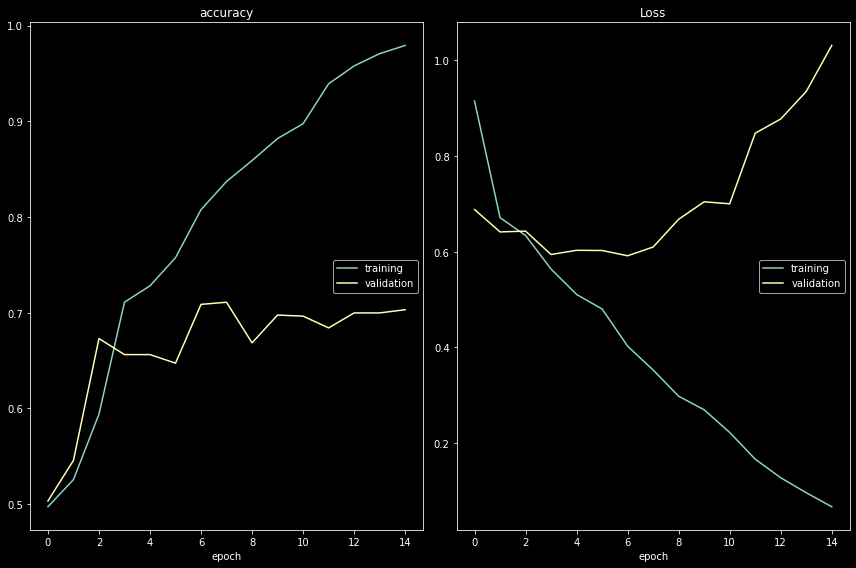

accuracy
	training         	 (min:    0.497, max:    0.979, cur:    0.979)
	validation       	 (min:    0.503, max:    0.711, cur:    0.703)
Loss
	training         	 (min:    0.067, max:    0.915, cur:    0.067)
	validation       	 (min:    0.592, max:    1.031, cur:    1.031)
Training Accuracy Threshold: 0.9791666865348816 / 0.977
Wall time: 1min 14s


In [17]:
%%time
pbar.display()
pbar.display()
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    verbose=0,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    callbacks=[pbar,plot,acc_callback]
)
# history = model.fit(x_train, y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=0,
#                     validation_data=(x_test, y_test), 
#                     callbacks=[pbar,plot,acc_callback]
#                     )
# score = model.evaluate(x_test, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(20, 10))

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<AxesSubplot:>

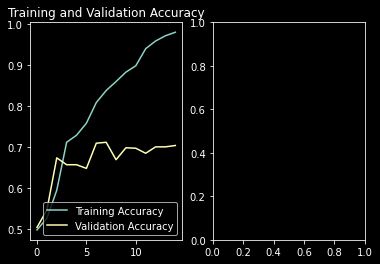

In [25]:
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)

# Assignment 